# Import Library and Upload Data

In [ ]:
!pip install --upgrade transformers huggingface_hub
!pip install pyarrow

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from transformers import AutoModel, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim
from collections import defaultdict
import time
import pickle
from torch.utils.data import WeightedRandomSampler

2025-11-22 10:06:21.866945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763805982.255096     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763805982.364549     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Data Preprocessing

## Preparing column for sentiment analysis

In [2]:
merged_df = pd.read_parquet('/kaggle/input/df-top-5-cp/sample_df_top5_cellphone.parquet')
merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days
0,5,True,2012-09-28,AN50X7CK243DC,B005NF5NTK,msaridar,I got this product for my mom since she replac...,1348790400,909,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
1,5,True,2012-09-08,A34TJ1Z3UVGELL,B005NF5NTK,JS,"it charges my LG ""dumb"" phone, my echo ecigs, ...",1347062400,None,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
2,5,True,2012-05-22,AMM4QAFLI50X4,B005NF5NTK,carlos adame,"As I received a use in my mobile, and I was ou...",1337644800,None,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
3,5,True,2012-04-02,A253LFJJDRENNQ,B005NF5NTK,KB,Very compact but able to almost fully charge a...,1333324800,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398
4,4,True,2012-02-20,A3GBQUB4A44C4I,B005NF5NTK,Professor305,"Charged my HTC Amaze 4G to 75%, with it being ...",1329696000,7,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398


In [ ]:
# ensure there is no empty column or row. sort value by reviewTime
merged_df = merged_df.dropna(axis=1, how='all')
merged_df = merged_df.sort_values(by='reviewTime').reset_index(drop=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61146 entries, 0 to 61145
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   overall             61146 non-null  int64         
 1   verified            61146 non-null  bool          
 2   reviewTime          61146 non-null  datetime64[ns]
 3   reviewerID          61146 non-null  object        
 4   asin                61146 non-null  object        
 5   reviewerName        61141 non-null  object        
 6   reviewText          61146 non-null  object        
 7   unixReviewTime      61146 non-null  int64         
 8   vote                1598 non-null   object        
 9   title               61146 non-null  object        
 10  rank                61146 non-null  object        
 11  main_cat            61146 non-null  object        
 12  date                11091 non-null  object        
 13  price               61146 non-null  object    

In [ ]:
# map sentiment into positive and negative

def map_sentiment(score):
    if score >= 4: # map positive
        return 1 
    else:  # map negative
        return 0 
        
merged_df['sentiment'] = merged_df['overall'].apply(map_sentiment)
print(merged_df['sentiment'].dtype) 

int64


In [ ]:
# map asin, which is product id, into unique id from 0 to n-1
unique_asins = merged_df['asin'].unique()
asin_to_id = {asin: idx for idx, asin in enumerate(unique_asins)}
id_to_asin = {idx: asin for asin, idx in asin_to_id.items()}
merged_df['asin_id'] = merged_df['asin'].map(asin_to_id)

asin_mapping_df = pd.DataFrame({'asin': list(asin_to_id.keys()), 'asin_id': list(asin_to_id.values())})
asin_mapping_df.to_csv('asin_mapping.csv', index=False)
merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days,sentiment,asin_id
0,4,True,2011-11-30,A2NH1QZRL3KEXM,B005NF5NTK,Der Kaiser,I thought the cylinder type charger was worth ...,1322611200,2,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
1,5,True,2011-12-22,A13NSKPTIRSSQS,B005NF5NTK,callmebob,"Having the Evo 4g, battery life is something t...",1324512000,2,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
2,5,False,2012-01-14,A2H1CCSN6M4QNU,B005NF5NTK,Al-Sayed Khalid,when i first got this was happy on how small i...,1326499200,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
3,4,True,2012-02-20,A3GBQUB4A44C4I,B005NF5NTK,Professor305,"Charged my HTC Amaze 4G to 75%, with it being ...",1329696000,7,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0
4,5,True,2012-04-02,A253LFJJDRENNQ,B005NF5NTK,KB,Very compact but able to almost fully charge a...,1333324800,4,"Anker PowerCore+ Mini, 3350mAh Lipstick-Sized ...","['>#6,626 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$23.99,13095,2011-11-30,2018-06-24,2398,1,0


In [ ]:
# count number of reviews per year
print("Reviews per year:")
yearly_counts = (merged_df['reviewTime'].dt.year.value_counts().sort_index())
print(yearly_counts)

Reviews per year:
reviewTime
2011        2
2012        6
2014      705
2015    17999
2016    24137
2017    12855
2018     5442
Name: count, dtype: int64


In [ ]:
# only use data from 2015 since 2011-2014 has low amount of data 
merged_df = merged_df[merged_df['reviewTime'].dt.year>=2015].copy()
merged_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,unixReviewTime,vote,title,rank,main_cat,date,price,Review_Count,Min_Date,Max_Date,Review_Period_Days,sentiment,asin_id
713,5,True,2015-01-01,A356R2YBP9PWPB,B00MQSMDYU,Sue,Very pleased. This product is great.,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
714,1,True,2015-01-01,A2GJ4YPGG6W87,B00MQSMDYU,Amazon Customer,It was great when I first got it and then it s...,1420070400,6,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,0,1
715,5,True,2015-01-01,A35NYLTL57C84W,B00MQSMDYU,chris fountain,Best portable battery pack that I have owned. ...,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
716,5,True,2015-01-01,A1XFG7PQ5V04MI,B00MQSMDYU,449greg,"Totally awesome,,,,just as advertised!! You wi...",1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1
717,5,True,2015-01-01,A2FVMF4VCRUKIW,B00MQSMDYU,C. Parker,awesome,1420070400,None,Portable Chargers 16750 RAVPower 16750mAh Exte...,"['>#5,286 in Cell Phones & Accessories (See To...",Cell Phones & Accessories,None,$37.99,13465,2014-09-11,2018-08-09,1428,1,1


### Handle text preprocessing

In [ ]:
def text_preprocessing(text):
    text = str(text)
    text = ' '.join(text.split())
    return text

class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # Apply Simple Preprocessing 
        review_text = text_preprocessing(row['reviewText'])
        
        # Tokenization 
        encoding = self.tokenizer.encode_plus(
            review_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', 
        )
        
        # Additional Features (ID) and Targets 
        asin_id = torch.tensor(row['asin_id'], dtype=torch.long)
        sentiment_label = torch.tensor(row['sentiment'], dtype=torch.long)

        # setup for data loader
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'asin_id': asin_id,
            'targets': sentiment_label
        }

2015    17999
2016    24137
-------------+
        42136 (train, 0.7)
        
2017    12855 (val, 0.2)
2018     5442 (test, 0.1)


In [ ]:
def create_data_loaders(df, tokenizer, max_len, batch_size, main_train_ratio=0.8, val_in_train_ratio=0.2):
    # Sort the entire dataset by the review time column before splitting
    df = df.sort_values(by='reviewTime').reset_index(drop=True)
    
    # Split to train, val, and test
    total_size = len(df)
    outer_train_size = int(main_train_ratio * total_size)
    train_val_df = df[df['reviewTime'].dt.year.isin([2015, 2016, 2017])]
    test_df = df[df['reviewTime'].dt.year == 2018]
    train_df = df[df['reviewTime'].dt.year.isin([2015, 2016])]
    val_df = df[df['reviewTime'].dt.year == 2017]

    # calculate the weights for the imbalanced dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_labels = train_val_df['sentiment'].values
    classes = np.unique(train_labels)
    weights_np = compute_class_weight("balanced", classes=classes, y=train_labels)
    weights_tensor = torch.tensor(weights_np, dtype=torch.float).to(device)
    print(f"Weights (Tensor): {weights_tensor}")

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print(f"Train Set: {len(train_df)} reviews, ({len(train_df)/total_size*100:.2f}% of total)")
    print(f"Validation Set: {len(val_df)} reviews, ({len(val_df)/total_size*100:.2f}% of total)")
    print(f"Test Set: {len(test_df)} reviews, ({len(test_df)/total_size*100:.2f}% of total)")
    
    # call ReviewDataset
    train_dataset = ReviewDataset(train_df, tokenizer, max_len)
    val_dataset = ReviewDataset(val_df, tokenizer, max_len)
    test_dataset = ReviewDataset(test_df, tokenizer, max_len)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_data_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_data_loader, val_data_loader, test_data_loader, weights_tensor

# Training Model 

In [ ]:
class TemporalBERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_sentiment_classes, num_unique_products, product_embedding_dim=50):
        super(TemporalBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        bert_output_dim = self.bert.config.hidden_size 
        
        # embedding for product id
        self.product_embedding = nn.Embedding(
            num_embeddings=num_unique_products,  # Total count of unique products
            embedding_dim=product_embedding_dim     
        )
    
        total_combined_dim = (
            bert_output_dim +                  
            product_embedding_dim                
        )  
        
        self.batch_norm = nn.BatchNorm1d(total_combined_dim)
        
        # Final Classification 
        self.classifier = nn.Sequential(
            nn.Linear(total_combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_sentiment_classes)
        )

    def forward(self, input_ids, attention_mask, asin_id):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract the vector for the [CLS] token 
        cls_output = outputs.last_hidden_state[:, 0, :] 
        
        # embedding the product id
        product_vec = self.product_embedding(asin_id) 

        # Concatenate all features
        combined_features = torch.cat([
            cls_output,                 # BERT output
            product_vec                # ID embedding
        ], dim=-1)

        combined_features = self.batch_norm(combined_features)
        logits = self.classifier(combined_features)
        return logits

In [ ]:
def train_epoch_fn(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model = model.train()  # Set model to training mode
    
    losses = []
    all_targets = []
    all_preds = []

    for data in tqdm(data_loader, desc="Training"):
        # Move tensors to the target DEVICE
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        
        # Set custom Features
        asin_id = data['asin_id'].to(device)
        
        # Set target Label
        targets = data['targets'].to(device)

        # Forward Pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            asin_id=asin_id
        )
        
        # Calculate Loss
        loss = loss_fn(outputs, targets)
        
        # Get the predicted class results
        _, preds = torch.max(outputs, dim=1)
        
        # Store the results for evaluation with metrics
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        losses.append(loss.item())
        
        # Backward Pass 
        optimizer.zero_grad() 
        loss.backward()       
        
        # Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()      
        
        # Update the learning rate
        if scheduler:
            scheduler.step() 

    # calculate the average loss, accuracy, and macro f1 score
    avg_loss = sum(losses) / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    return avg_loss, accuracy, macro_f1, report

In [ ]:
def eval_epoch_fn(model, data_loader, loss_fn, device, desc="Evaluation"):
    model = model.eval()  # Set model to evaluation mode
    
    losses = []
    all_targets = []
    all_preds = []
    
    with torch.no_grad(): 
        for data in tqdm(data_loader, desc=desc):
            # Move all tensors to the target device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            
            # set extra features
            asin_id = data['asin_id'].to(device)
            
            # set target Label
            targets = data['targets'].to(device)

            # Forward Pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                asin_id=asin_id
            )
            
            # Calculate Loss
            loss = loss_fn(outputs, targets)
            
            # Get the predicted class 
            _, preds = torch.max(outputs, dim=1)

            # store the results for evaluation with metrics
            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # calculate the average loss, accuracy, and macro f1 score
    avg_loss = sum(losses) / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    return avg_loss, accuracy, macro_f1, report

In [ ]:
# Configuration and Setup
model_name = 'bert-base-uncased'
max_len = 256
batch_size = 16
num_epochs = 4
custom_layer_lr = 1e-4
bert_fine_tune_lr = 2e-5
embedding_dim = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_unique_products = merged_df['asin_id'].nunique()
num_sentiment_classes = merged_df['sentiment'].nunique()

# setup data
tokenizer = BertTokenizer.from_pretrained(model_name)
train_loader, val_loader, test_loader, weights_tensor = create_data_loaders(df=merged_df, tokenizer=tokenizer, max_len= max_len, batch_size=batch_size)
print(f"Training batches ready: {len(train_loader)}")
print(f"Validation batches ready: {len(val_loader)}")
print(f"Test batches ready: {len(test_loader)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Weights (Tensor): tensor([3.2748, 0.5901], device='cuda:0')
Train Set: 42136 reviews, (69.72% of total)
Validation Set: 12855 reviews, (21.27% of total)
Test Set: 5442 reviews, (9.01% of total)
Training batches ready: 2634
Validation batches ready: 804
Test batches ready: 341


In [ ]:
# setup model
model = TemporalBERTClassifier(bert_model_name=model_name, num_sentiment_classes=num_sentiment_classes, num_unique_products=num_unique_products)
model.to(device)

# prepare for two phase training, where the BERT model is frozen for the first 2 epochs
for param in model.bert.parameters():
    param.requires_grad = False
bert_param_ids = set(id(p) for p in model.bert.parameters())

# setup loss, optimizer, scheduler
class_weights = weights_tensor.clone()
class_weights[0] = class_weights[0] * 2.0
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device) 
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=custom_layer_lr)

# setup scheduler
total_steps = len(train_loader) * num_epochs 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
history = defaultdict(list)
best_f1 = 0

print(f"\n Starting Training for {num_epochs} Epochs")
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # when epoch 3 starts, unfroze the bert model
    if epoch == 3:
        for param in model.bert.parameters():
            param.requires_grad = True

        optimizer_grouped_parameters = [
            {'params': model.bert.parameters(), 'lr': bert_fine_tune_lr}, # bert layers 
            {'params': [p for p in model.parameters() if p.requires_grad and id(p) not in bert_param_ids], 'lr': custom_layer_lr}] # Custom layers
        
        # set new optimizer
        optimizer = optim.AdamW(optimizer_grouped_parameters)
        # set new scheduler
        remaining_steps = len(train_loader) * (num_epochs - epoch + 1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=remaining_steps)
        
    print(f"\nEpoch {epoch} / {NUM_EPOCHS}")
    print("------------------------------------------------------------")

    # training
    train_loss, train_acc, train_f1, train_report = train_epoch_fn(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Train F1-Score: {train_f1:.4f} | Train Report: {train_report}")
    
    # validation
    val_loss, val_acc, val_f1, val_report = eval_epoch_fn(model, val_loader, loss_fn, device, desc="Validating")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f} | Validation Report: {val_report}")

    # Save training history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_report'].append(train_report)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_report'].append(val_report)
    
    # If the current validation accuracy is the best we've seen, save the model state
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_f1.model')
        print(f"Model saved! New best validation f1 score: {best_f1:.4f}")

end_time = time.time()
print(f"\n--- Training Finished in {(end_time - start_time) / 60:.2f} minutes ---")


 Starting Training for 4 Epochs

Epoch 1 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [11:22<00:00,  3.86it/s]


Train Loss: 0.3508 | Train Accuracy: 0.8668 | Train F1-Score: 0.7808 | Train Report: {'0': {'precision': 0.5209168465412684, 'recall': 0.8417206444112274, 'f1-score': 0.6435555555555554, 'support': 6021}, '1': {'precision': 0.9705927731662912, 'recall': 0.870940052609719, 'f1-score': 0.918070108870144, 'support': 36115}, 'accuracy': 0.8667647617239416, 'macro avg': {'precision': 0.7457548098537798, 'recall': 0.8563303485104732, 'f1-score': 0.7808128322128497, 'support': 42136}, 'weighted avg': {'precision': 0.9063365847713496, 'recall': 0.8667647617239416, 'f1-score': 0.8788435063092188, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:25<00:00,  3.91it/s]


Validation Loss: 0.3376 | Validation Accuracy: 0.9230 | Validation F1-Score: 0.8764 | Validation Report: {'0': {'precision': 0.7674777906527617, 'recall': 0.8366315789473684, 'f1-score': 0.8005640612409347, 'support': 2375}, '1': {'precision': 0.9622053380089616, 'recall': 0.9425572519083969, 'f1-score': 0.9522799575821845, 'support': 10480}, 'accuracy': 0.9229871645274212, 'macro avg': {'precision': 0.8648415643308616, 'recall': 0.8895944154278826, 'f1-score': 0.8764220094115596, 'support': 12855}, 'weighted avg': {'precision': 0.9262288366498815, 'recall': 0.9229871645274212, 'f1-score': 0.9242499884020625, 'support': 12855}}
Model saved! New best validation f1 score: 0.8764

Epoch 2 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [11:31<00:00,  3.81it/s]


Train Loss: 0.3384 | Train Accuracy: 0.9000 | Train F1-Score: 0.8219 | Train Report: {'0': {'precision': 0.6099549714007545, 'recall': 0.8324198638099983, 'f1-score': 0.704031465093412, 'support': 6021}, '1': {'precision': 0.9702526607506118, 'recall': 0.911255710923439, 'f1-score': 0.9398292258046093, 'support': 36115}, 'accuracy': 0.8999905069299411, 'macro avg': {'precision': 0.7901038160756831, 'recall': 0.8718377873667187, 'f1-score': 0.8219303454490106, 'support': 42136}, 'weighted avg': {'precision': 0.9187681252566046, 'recall': 0.8999905069299411, 'f1-score': 0.9061350375275511, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:25<00:00,  3.91it/s]


Validation Loss: 0.2997 | Validation Accuracy: 0.9257 | Validation F1-Score: 0.8821 | Validation Report: {'0': {'precision': 0.7669172932330827, 'recall': 0.8589473684210527, 'f1-score': 0.8103277060575969, 'support': 2375}, '1': {'precision': 0.9671407552721922, 'recall': 0.9408396946564885, 'f1-score': 0.9538089480048367, 'support': 10480}, 'accuracy': 0.9257098405289771, 'macro avg': {'precision': 0.8670290242526375, 'recall': 0.8998935315387706, 'f1-score': 0.8820683270312168, 'support': 12855}, 'weighted avg': {'precision': 0.9301488671086072, 'recall': 0.9257098405289771, 'f1-score': 0.9273003560464785, 'support': 12855}}
Model saved! New best validation f1 score: 0.8821

Epoch 3 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [32:28<00:00,  1.35it/s]


Train Loss: 0.3300 | Train Accuracy: 0.9428 | Train F1-Score: 0.8881 | Train Report: {'0': {'precision': 0.7705802968960864, 'recall': 0.8535127055306427, 'f1-score': 0.8099290780141843, 'support': 6021}, '1': {'precision': 0.9751318126709335, 'recall': 0.9576353315796761, 'f1-score': 0.9663043781956357, 'support': 36115}, 'accuracy': 0.9427567875450921, 'macro avg': {'precision': 0.87285605478351, 'recall': 0.9055740185551594, 'f1-score': 0.88811672810491, 'support': 42136}, 'weighted avg': {'precision': 0.9459025389743235, 'recall': 0.9427567875450921, 'f1-score': 0.9439592177059709, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:25<00:00,  3.90it/s]


Validation Loss: 0.3756 | Validation Accuracy: 0.9593 | Validation F1-Score: 0.9312 | Validation Report: {'0': {'precision': 0.9100974313551816, 'recall': 0.8652631578947368, 'f1-score': 0.887114180876322, 'support': 2375}, '1': {'precision': 0.9698027743701048, 'recall': 0.9806297709923664, 'f1-score': 0.975186221948095, 'support': 10480}, 'accuracy': 0.959315441462466, 'macro avg': {'precision': 0.9399501028626431, 'recall': 0.9229464644435517, 'f1-score': 0.9311502014122085, 'support': 12855}, 'weighted avg': {'precision': 0.9587720322728319, 'recall': 0.959315441462466, 'f1-score': 0.9589146468764916, 'support': 12855}}
Model saved! New best validation f1 score: 0.9312

Epoch 4 / 4
------------------------------------------------------------


Training: 100%|██████████| 2634/2634 [32:25<00:00,  1.35it/s]


Train Loss: 0.2073 | Train Accuracy: 0.9715 | Train F1-Score: 0.9424 | Train Report: {'0': {'precision': 0.8914879792072774, 'recall': 0.9114764989204451, 'f1-score': 0.9013714379568037, 'support': 6021}, '1': {'precision': 0.9851862145636465, 'recall': 0.981503530389035, 'f1-score': 0.983341424509328, 'support': 36115}, 'accuracy': 0.9714970571482817, 'macro avg': {'precision': 0.938337096885462, 'recall': 0.9464900146547401, 'f1-score': 0.9423564312330659, 'support': 42136}, 'weighted avg': {'precision': 0.9717972579687942, 'recall': 0.9714970571482817, 'f1-score': 0.9716283694250119, 'support': 42136}}


Validating: 100%|██████████| 804/804 [03:28<00:00,  3.86it/s]


Validation Loss: 0.3286 | Validation Accuracy: 0.9622 | Validation F1-Score: 0.9371 | Validation Report: {'0': {'precision': 0.9003815175922001, 'recall': 0.8943157894736842, 'f1-score': 0.897338403041825, 'support': 2375}, '1': {'precision': 0.9760861280487805, 'recall': 0.9775763358778626, 'f1-score': 0.9768306636155606, 'support': 10480}, 'accuracy': 0.962193698949825, 'macro avg': {'precision': 0.9382338228204903, 'recall': 0.9359460626757734, 'f1-score': 0.9370845333286928, 'support': 12855}, 'weighted avg': {'precision': 0.9620994730636091, 'recall': 0.962193698949825, 'f1-score': 0.9621442288537854, 'support': 12855}}
Model saved! New best validation f1 score: 0.9371

--- Training Finished in 101.63 minutes ---


In [ ]:
# Final Evaluation (Testing) 
model.load_state_dict(torch.load('/kaggle/working/best_f1.model'))

test_loss, test_acc, test_f1, test_report = eval_epoch_fn(model, test_loader, loss_fn, device, desc="Testing")
print(f"Final Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.4f} | Final Test F1-Score: {test_f1:.4f} | Final Test Report: {test_report}")

Testing: 100%|██████████| 341/341 [01:28<00:00,  3.86it/s]

Final Test Loss: 0.3257 | Final Test Accuracy: 0.9588 | Final Test F1-Score: 0.9300 | Final Test Report: {'0': {'precision': 0.8760162601626016, 'recall': 0.8941908713692946, 'f1-score': 0.8850102669404518, 'support': 964}, '1': {'precision': 0.9771197846567967, 'recall': 0.9727556945064761, 'f1-score': 0.9749328558639213, 'support': 4478}, 'accuracy': 0.9588386622565234, 'macro avg': {'precision': 0.9265680224096992, 'recall': 0.9334732829378853, 'f1-score': 0.9299715614021866, 'support': 5442}, 'weighted avg': {'precision': 0.9592102297849842, 'recall': 0.9588386622565234, 'f1-score': 0.9590039003839094, 'support': 5442}}


In [ ]:
history['test_loss'].append(test_loss)
history['test_acc'].append(test_acc)
history['test_f1'].append(test_f1)
history['test_report'].append(test_report)

final_history = dict(history)
final_history

{'train_loss': [0.35080949186001625,
  0.33842613743763095,
  0.33001260384056963,
  0.20732421700546735],
 'train_acc': [0.8667647617239416,
  0.8999905069299411,
  0.9427567875450921,
  0.9714970571482817],
 'train_f1': [0.7808128322128497,
  0.8219303454490106,
  0.88811672810491,
  0.9423564312330659],
 'train_report': [{'0': {'precision': 0.5209168465412684,
    'recall': 0.8417206444112274,
    'f1-score': 0.6435555555555554,
    'support': 6021},
   '1': {'precision': 0.9705927731662912,
    'recall': 0.870940052609719,
    'f1-score': 0.918070108870144,
    'support': 36115},
   'accuracy': 0.8667647617239416,
   'macro avg': {'precision': 0.7457548098537798,
    'recall': 0.8563303485104732,
    'f1-score': 0.7808128322128497,
    'support': 42136},
   'weighted avg': {'precision': 0.9063365847713496,
    'recall': 0.8667647617239416,
    'f1-score': 0.8788435063092188,
    'support': 42136}},
  {'0': {'precision': 0.6099549714007545,
    'recall': 0.8324198638099983,
    'f1-

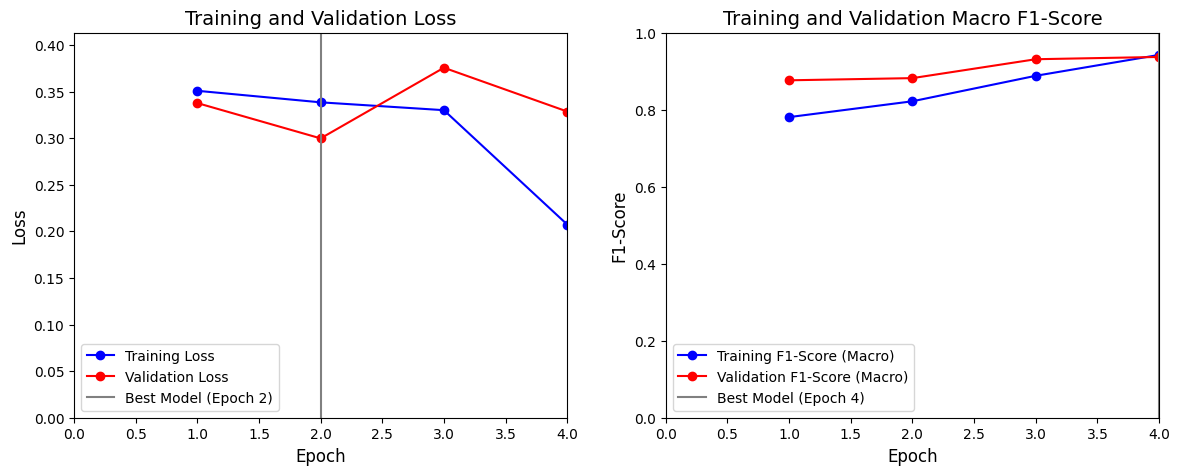

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(14, 5))

# plot 1
plt.subplot(1, 2, 1) 
plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
best_epoch_loss = np.argmin(history['val_loss']) + 1
plt.axvline(x=best_epoch_loss, color='gray', linestyle='-', label=f'Best Model (Epoch {best_epoch_loss})')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1) 
plt.xlim(0, len(epochs))

# plot 2: f1-score curve
plt.subplot(1, 2, 2) 
plt.plot(epochs, history['train_f1'], 'b-o', label='Training F1-Score (Macro)')
plt.plot(epochs, history['val_f1'], 'r-o', label='Validation F1-Score (Macro)')
best_epoch_f1 = np.argmax(history['val_f1']) + 1
plt.axvline(x=best_epoch_f1, color='gray', linestyle='-', label=f'Best Model (Epoch {best_epoch_f1})')
plt.title('Training and Validation Macro F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, len(epochs))
plt.show()